In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from vgg16 import VGG16
import pickle
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Concatenate, Add, Activation, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional
import json
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image

In [10]:
%ls ./annotations

captions_train2014.json   instances_val2014.json
captions_val2014.json     person_keypoints_train2014.json
image_info_test2014.json  person_keypoints_val2014.json
instances_train2014.json


In [13]:
token = './annotations/captions_train2014.json'

In [14]:
json_data = open(token)

In [15]:
captions = json.load(json_data)

In [90]:
for i, val in enumerate(captions['annotations']):
    if i<10:
        print (val)

{'caption': 'A very clean and well decorated empty bathroom', 'image_id': 318556, 'id': 48}
{'caption': 'A panoramic view of a kitchen and all of its appliances.', 'image_id': 116100, 'id': 67}
{'caption': 'A blue and white bathroom with butterfly themed wall tiles.', 'image_id': 318556, 'id': 126}
{'caption': 'A panoramic photo of a kitchen and dining room', 'image_id': 116100, 'id': 148}
{'caption': 'A graffiti-ed stop sign across the street from a red car ', 'image_id': 379340, 'id': 173}
{'caption': 'A vandalized stop sign and a red beetle on the road', 'image_id': 379340, 'id': 188}
{'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.', 'image_id': 318556, 'id': 219}
{'caption': 'An angled view of a beautifully decorated bathroom.', 'image_id': 318556, 'id': 255}
{'caption': 'The two people are walking down the beach.', 'image_id': 134754, 'id': 272}
{'caption': 'A sink and a toilet inside a small bathroom.', 'image_id': 538480, 'id': 288}


In [16]:
for i, val in enumerate(captions['images']):
    if i<2:
        print (val)

{'license': 5, 'file_name': 'COCO_train2014_000000057870.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-14 16:28:13', 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg', 'id': 57870}
{'license': 5, 'file_name': 'COCO_train2014_000000384029.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg', 'height': 429, 'width': 640, 'date_captured': '2013-11-14 16:29:45', 'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg', 'id': 384029}


## Creating a dictionary containing all the captions of the images

In [17]:
images = './train2014/'
len(images)

12

In [18]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [19]:
img[:5]

['./train2014/COCO_train2014_000000361778.jpg',
 './train2014/COCO_train2014_000000498015.jpg',
 './train2014/COCO_train2014_000000517882.jpg',
 './train2014/COCO_train2014_000000211807.jpg',
 './train2014/COCO_train2014_000000422850.jpg']

In [20]:
image2id = {}

for i, val in enumerate(captions['images']):
    image2id[val['id']] = val['file_name']

In [21]:
id2captions = {}

for i, val in enumerate(captions['annotations']):
    id2captions[val['image_id']] = val['caption']

In [22]:
image2caption = {}
for key, val in id2captions.items():
    image2caption[image2id[key]] = val

In [23]:
len(image2caption)

82783

In [24]:
image2caption['COCO_train2014_000000522971.jpg']

'A woman in black and grey jacket skiing on a slope.'

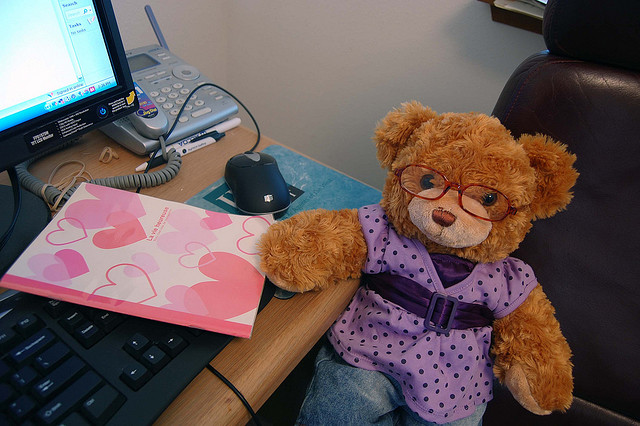

In [25]:
Image.open(img[0])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [26]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [27]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

W0511 21:47:01.188529 140662191711616 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


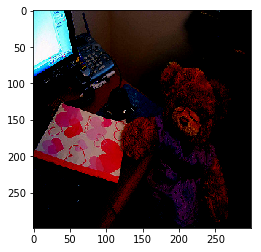

In [28]:
plt.imshow(np.squeeze(preprocess(img[0])))

In [29]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 2s 0us/step


In [31]:
from tensorflow.keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [32]:
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
______________________________________________________________________________________________

In [33]:
tryi = model_new.predict(preprocess(img[0]))

In [34]:
tryi.shape

(1, 2048)

In [35]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

# Need to complete this process

In [36]:
encoding_train = {}
for img in tqdm(img):
    encoding_train[img[len(images):]] = encode(img)

  0%|          | 56/82783 [00:19<7:55:21,  2.90it/s]

KeyboardInterrupt: 

In [217]:
for key, val in encoding_train.items():
    print (key)
    print (val.shape)
    break

COCO_train2014_000000021223.jpg
(2048,)


Calculating the unique words in the vocabulary.

In [116]:
caps = []
for key, val in image2caption.items():
    caps.append(' '.join(list(val.split())))
    
caps[:5]

['Towels with palm trees on them hanging from a towel bar.',
 'A grey and black motorcycle parked on a sidewalk.',
 'Two cats looking bogeyed at a bird picking up something.',
 'The wetsuit hints that this is cold water.',
 'A beautiful young woman holding a tennis racquet on a tennis court.']

In [117]:
words = [i.split() for i in caps]

In [121]:
unique = []
for i in words:
    unique.extend(i)

In [122]:
unique.extend("<start>".split())
unique.extend("<end>".split())
unique.extend("<unk>".split())

In [123]:
unique = list(set(unique))

In [33]:
# with open("unique.p", "wb") as pickle_d:
#     pickle.dump(unique, pickle_d) 

In [124]:
len(unique)

21315

Mapping the unique words to indices and vice-versa

In [125]:
word2idx = {val:index for index, val in enumerate(unique)}

In [126]:
word2idx['<start>']

1905

In [127]:
idx2word = {index:val for index, val in enumerate(unique)}

In [129]:
idx2word[1905]

'<start>'

Calculating the maximum length among all the captions

In [130]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

49

In [131]:
len(unique), max_len

(21315, 49)

In [132]:
vocab_size = len(unique)

In [133]:
vocab_size

21315

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [181]:
f = open('mscoco_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [182]:
for key, val in image2caption.items():
    f.write(key + "\t" + "<start> " + val +" <end>" + "\n")

f.close()

In [200]:
df = pd.read_csv('mscoco_training_dataset.txt', delimiter='\t')

In [201]:
df = df.dropna()

In [202]:
df.head()

,image_id,captions
0,COCO_train2014_000000213391.jpg,<start> Towels with palm trees on them hanging...
1,COCO_train2014_000000421877.jpg,<start> A grey and black motorcycle parked on ...
2,COCO_train2014_000000173814.jpg,<start> Two cats looking bogeyed at a bird pic...
3,COCO_train2014_000000574052.jpg,<start> The wetsuit hints that this is cold wa...
4,COCO_train2014_000000050562.jpg,<start> A beautiful young woman holding a tenn...


In [203]:
len(df)

82783

In [204]:
c = [i for i in df['captions']]

In [205]:
imgs = [i for i in df['image_id']]

In [206]:
a = c[0]
a, imgs[0]

('<start> Towels with palm trees on them hanging from a towel bar. <end>',
 'COCO_train2014_000000213391.jpg')

In [207]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 1905
Towels => 19618
with => 18716
palm => 19471
trees => 6896
on => 12596
them => 617
hanging => 8001
from => 14909
a => 12444
towel => 16741
bar. => 9863
<end> => 19793


In [208]:
samples_per_epoch = 0
for ca in c:
    samples_per_epoch = samples_per_epoch + len(ca.split())-1

In [209]:
samples_per_epoch

948248

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [218]:
def data_generator(df, batch_size=32):
    # Shuffling the dataframe before creating batches
#     df = df.sample(frac=1)
#     c = [i for i in df['captions']]
#     imgs = [i for i in df['image_id']]
    
    partial_caps = []
    images = []
    next_words = []
    count = 0
    for i, text in enumerate(c[:1000]):
        current_image = encoding_train[imgs[i]]
        for j in range(len(text.split())-1):
            count+=1
            if text.split()[j] in word2idx:
                partial = [word2idx[text.split()[j]]]
            else:
                partial = [word2idx['<unk>']]
            partial_caps.append(partial)
            # Initializing with zeros to create a one-hot encoding matrix
            # This is what we have to predict
            # Hence initializing it with vocab_size length
            next = np.zeros(vocab_size)
            # Setting the next word to 1
            if text.split()[j+1] in word2idx:
                next[word2idx[text.split()[j+1]]] = 1
            else:
                next[word2idx['<unk>']] = 1
            next_words.append(next)
            images.append(current_image)
            
            if count >= batch_size:
                images = np.array(images)
                next_words = np.array(next_words)
                partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                yield [[images, partial_caps], next_words]
                partial_caps = []
                images = []
                next_words = []
                count = 0
    
    
#     partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
#     return np.array(partial_caps)

In [219]:
for i, val in enumerate(data_generator(df)):
    if i==0:
        print (val)


# partial_caps = []
# next_words = []
# images = []

# partial_caps = data_generator(partial_caps, next_words, images)

KeyError: 'COCO_train2014_000000213391.jpg'

In [80]:
partial_caps.shape

(383454, 38)

## Let's create the model

In [180]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [50]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(1)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [51]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Merging the models and creating a softmax classifier

In [52]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [53]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [52]:
final_model.fit_generator(data_generator(df, batch_size=128), samples_per_epoch=382080, nb_epoch=1, verbose=2)

Epoch 1/1
588s - loss: 3.9429 - acc: 0.3332


## Predict funtion

In [58]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
#         par_caps = [word2idx[i] for i in start_word]
        par_caps = [word2idx[start_word[-1]]]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        if word_pred in word2idx:
            start_word.append(word_pred)
        else:
            # <UND> is undefined
            start_word.append("<UND>")
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

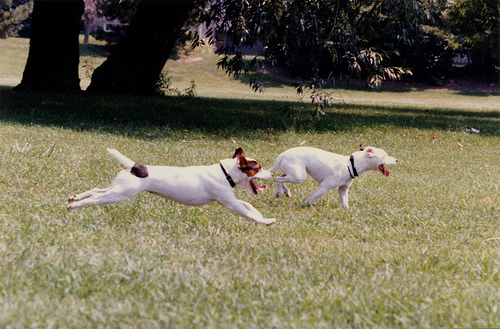

In [59]:
try_image = test_img[0]
Image.open(try_image)

In [109]:
print (predict_captions(try_image))

A white dog is running through a field .


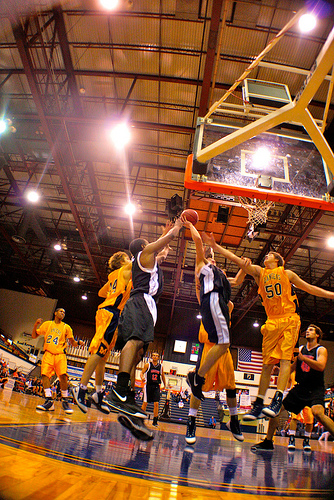

In [75]:
try_image2 = test_img[10]
Image.open(try_image2)

In [110]:
print (predict_captions(try_image2))

A group of people are playing basketball in the air .


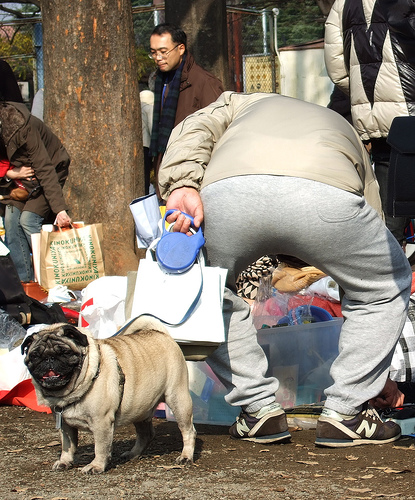

In [112]:
try_image3 = test_img[3]
Image.open(try_image3)

In [113]:
print (predict_captions(try_image3))

A man and white dog .
